# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from scripts.preprocessing import data_preprocessing, principal_components
from imblearn.over_sampling import SMOTE

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../files/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=object)
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1,8,NaN,NaN,NaN,NaN,8,15,...,5,2,1,6,9,3,3,0,2,4
1,1771,1,4,13,NaN,NaN,NaN,NaN,13,1,...,1,2,1,4,9,7,1,0,2,3
2,1776,1,1,9,NaN,NaN,NaN,NaN,7,0,...,6,4,2,NaN,9,2,3,0,1,4
3,1460,2,1,6,NaN,NaN,NaN,NaN,6,4,...,8,11,11,6,9,1,3,0,2,4
4,1783,2,1,9,NaN,NaN,NaN,NaN,9,53,...,2,2,1,6,9,3,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1,0,NaN,NaN,NaN,NaN,10,1,...,1,1,1,4,8,7,1,0,1,4
42958,67629,-1,1,0,NaN,NaN,NaN,NaN,14,1,...,1,1,1,5,9,7,1,0,1,3
42959,68273,1,1,16,NaN,NaN,NaN,NaN,10,2,...,1,2,1,2,9,7,1,0,1,4
42960,68581,2,1,18,NaN,NaN,NaN,NaN,13,3,...,2,3,4,2,9,2,3,0,2,4


### Check classes

Classes are highly imbalanced. Over 98% of the classes fall into the '0' category. This may leady to predictions overfitting to this category.

In [3]:
dist = (mailout_train.RESPONSE.value_counts()/mailout_train.shape[0]*100).reset_index().rename(columns={"index":"CATEGORY"})
dist

,CATEGORY,RESPONSE
0,0,98.761696
1,1,1.238304


Text(0.5, 1.0, 'Category Distribution')

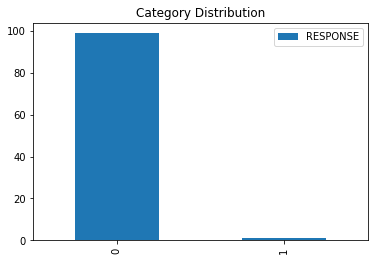

In [4]:
dist.plot.bar()
plt.title("Category Distribution")

## Data Preparation

The data from mailout_train will be treated the following way:
1. Data preprocessing steps defined in previous notebooks:
   * Data cleaning
   * Data scaling
2. Get principal components through PCA analysis.
3. Fix imbalanced classes with the SMOTE technique. This technique oversamples classes with a low count by creating synthetic samples.

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

#### Data Preprocessing

In [6]:
y = mailout_train['RESPONSE']

# Preprocess data
X = data_preprocessing(mailout_train)

Old Dataframe Shape: (42962, 367)

Succesfully removed 62 columns!
BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_KZ was not found in the DF
SOHO_FLAG was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
The columns below threshold: ['TITEL_KZ'] were removed.


#### Principal Component Analysis

In [7]:
# Get Principal Components 

X, X_pca = principal_components(X)

Variance Explained by all 101 principal components:  0.7050989870534948


#### Imbalance Classes Correction

There are different techniques for solving the imbalance problem. Synthetic Minority Oversampling Technique (SMOTE) will be applied. This technique creates synthetic samples from low count classes.

In [8]:
# Apply SMOTE to de data

sm = SMOTE(random_state=42, )
X, y = sm.fit_sample(X, y)

#### Split data into training and test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Model Testing

Three models will be tested for predicting if the person will become a customer:
1. Gradient Boosting
2. Random Forest
3. Ada Boost

### Metric

The main metric to use will be the ROC, since it is good at ranking predictions, while accuracy just how many observations were correctly classified.

### Gradient Boosting

Scores:
1. **ROC Area Under the Curce is of 88.69%**
2. Overall Accuracy is of 88.69%

In [30]:
# Generate pipeline to test different parameters
pipeline = Pipeline([('gb', GradientBoostingClassifier())])
pipeline.get_params()

{'memory': None,
 'steps': [('gb', GradientBoostingClassifier())],
 'verbose': False,
 'gb': GradientBoostingClassifier(),
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'deviance',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_impurity_split': None,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 100,
 'gb__n_iter_no_change': None,
 'gb__presort': 'deprecated',
 'gb__random_state': None,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': 0,
 'gb__warm_start': False}

In [11]:
# Parameters definition

parameters = {
    'gb__max_depth': range(3,5),
    'gb__random_state': [42]
}

# Gridsearch to test the parameters defined before.

cv = GridSearchCV(pipeline, param_grid=parameters)

start_time = time.time()

# Fit the model with the training data

cv.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1818.7994759082794 seconds ---


In [12]:
# Get the best parameters
print(cv.best_params_,'\n')

# Get the best estimator
print(cv.best_estimator_,'\n')

# Get the best score
print(cv.best_score_)

# Predict with the best parameters
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test)

# Print the overall Accuracy score
print(accuracy_score(y_test, y_pred))

# Print the ROC AUC score
print(roc_auc_score(y_test, y_pred))

{'gb__max_depth': 4, 'gb__random_state': 42} 

Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, random_state=42))]) 

0.8828970760819658
0.8869447221825454
0.8869169912135607


In [13]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     13983
           1       0.87      0.91      0.89     14021

    accuracy                           0.89     28004
   macro avg       0.89      0.89      0.89     28004
weighted avg       0.89      0.89      0.89     28004



### Random Forest

Scores:
1. **ROC Area Under the Curce is of 94.59%**
2. Overall Accuracy is of 94.59%

In [19]:
pipeline = Pipeline([('rf', RandomForestClassifier())])
pipeline.get_params()

{'memory': None,
 'steps': [('rf', RandomForestClassifier())],
 'verbose': False,
 'rf': RandomForestClassifier(),
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [20]:
# Parameters definition

parameters = {
    'rf__min_samples_leaf': [1, 2],
    'rf__min_samples_split': [2, 5],
    'rf__n_estimators': [100]
}

# Gridsearch to test the parameters defined before.

cv = GridSearchCV(pipeline, param_grid=parameters)

start_time = time.time()

# Fit the model with the training data

cv.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1303.576448917389 seconds ---


In [21]:
# Get the best parameters
print(cv.best_params_,'\n')

# Get the best estimator
print(cv.best_estimator_,'\n')

# Get the best score
print(cv.best_score_)

# Predict with the best parameters
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test)

# Print the overall Accuracy score
print(accuracy_score(y_test, y_pred))

# Print the ROC AUC score
print(roc_auc_score(y_test, y_pred))

{'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100} 

Pipeline(steps=[('rf', RandomForestClassifier())]) 

0.9449486049958373
0.9459005856306242
0.9459350348819086


In [22]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     13983
           1       0.97      0.92      0.94     14021

    accuracy                           0.95     28004
   macro avg       0.95      0.95      0.95     28004
weighted avg       0.95      0.95      0.95     28004



### Ada Boost Classifier

Scores:
1. **ROC Area Under the Curce is of 76.98%**
2. Overall Accuracy is of 76.99%

In [23]:
pipeline = Pipeline([('ab', AdaBoostClassifier())])
pipeline.get_params()

{'memory': None,
 'steps': [('ab', AdaBoostClassifier())],
 'verbose': False,
 'ab': AdaBoostClassifier(),
 'ab__algorithm': 'SAMME.R',
 'ab__base_estimator': None,
 'ab__learning_rate': 1.0,
 'ab__n_estimators': 50,
 'ab__random_state': None}

In [24]:
# Parameters definition

parameters = {
    'ab__n_estimators': [50,60,70],
    'ab__random_state': [42]
}

# Gridsearch to test the parameters defined before.

cv = GridSearchCV(pipeline, param_grid=parameters)

start_time = time.time()

# Fit the model with the training data

cv.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 563.7925889492035 seconds ---


In [25]:
# Get the best parameters
print(cv.best_params_,'\n')

# Get the best estimator
print(cv.best_estimator_,'\n')

# Get the best score
print(cv.best_score_)

# Predict with the best parameters
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test)

# Print the overall Accuracy score
print(accuracy_score(y_test, y_pred))

# Print the ROC AUC score
print(roc_auc_score(y_test, y_pred))

{'ab__n_estimators': 70, 'ab__random_state': 42} 

Pipeline(steps=[('ab', AdaBoostClassifier(n_estimators=70, random_state=42))]) 

0.7740959493844191
0.7698543065276389
0.7698167172877549


In [26]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76     13983
           1       0.76      0.80      0.78     14021

    accuracy                           0.77     28004
   macro avg       0.77      0.77      0.77     28004
weighted avg       0.77      0.77      0.77     28004



## Final Model

Random Forest is chosen as the final model, since it has the greatest ROC AUC score.

In [33]:
model = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators= 100, random_state= 42)
model.fit(X_train, y_train)

dump(model, 'model.joblib') 

['model.joblib']

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [44]:
# Load Model
model = load('model.joblib') 

In [38]:
# Load data to be predicted
mailout_test = pd.read_csv('../files/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=object)

In [39]:
# Clean data and apply PCA
X = data_preprocessing(mailout_test)
X, X_pca = principal_components(X)

Old Dataframe Shape: (42833, 366)

Succesfully removed 61 columns!
BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_KZ was not found in the DF
SOHO_FLAG was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
The columns below threshold: ['TITEL_KZ'] were removed.
Variance Explained by all 101 principal components:  0.7046784203442937


In [40]:
# Predict values
y_pred = model.predict(X)

In [41]:
# Prepare file for Kaggle competition
final_kaggle = pd.DataFrame()
final_kaggle['LNR'] = mailout_test['LNR']
final_kaggle['RESPONSE'] = y_pred

In [42]:
final_kaggle.to_csv("final_submission.csv", index=False)